In [1]:
from sentence_transformers import SentenceTransformer, util
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import re

2021-11-26 15:20:37.397904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/gaoag/.mujoco/mujoco200/bin
2021-11-26 15:20:37.398031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [52]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    if "stop" in sentences[:-1]:
        sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
# construction tuples of (emotion, [sentences], source, filename/path)
all_entries = []
for directory in ["./friendship/", "./loneliness/"]:
    emotion = directory.split('/')[1]
    for filename in os.listdir(directory):
        txtstring = open(directory + filename, 'r').read().split("|_|")
        sentence_string = txtstring[0].replace("\n", " ")
        try:
            source = txtstring[1]
        except IndexError as e:
            source = "Unknown"
        embedding = model.encode(sentence_string)
        all_entries.append((emotion, sentence_string, embedding, source, directory+filename))

In [12]:
# explore whether these embeddings are at all linearly separable:
# create some x that is (num_documents, num_features)
x = np.array([doc[2] for doc in all_entries])
y = np.array([doc[0] for doc in all_entries])
pca = PCA()
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

    

array([8.78623649e-02, 6.52584136e-02, 5.31680323e-02, 4.20591943e-02,
       4.03334238e-02, 3.56830247e-02, 2.94861980e-02, 2.65256930e-02,
       2.60229111e-02, 2.53379103e-02, 2.44553350e-02, 2.29444429e-02,
       2.17566900e-02, 1.96891129e-02, 1.94076803e-02, 1.83585398e-02,
       1.77713521e-02, 1.63432900e-02, 1.59611087e-02, 1.52388234e-02,
       1.50694605e-02, 1.44091295e-02, 1.39114466e-02, 1.33303711e-02,
       1.28385685e-02, 1.26313157e-02, 1.22350045e-02, 1.16021531e-02,
       1.10784825e-02, 1.06241712e-02, 9.82784200e-03, 9.69219208e-03,
       9.37041920e-03, 9.23963357e-03, 9.01197456e-03, 8.90600495e-03,
       8.45657755e-03, 8.11500102e-03, 7.97016639e-03, 7.73361744e-03,
       7.43481005e-03, 7.11218594e-03, 7.00749317e-03, 6.77796686e-03,
       6.45177392e-03, 6.27220515e-03, 6.04532519e-03, 5.68794366e-03,
       5.59403468e-03, 5.46545675e-03, 5.34156058e-03, 5.19418577e-03,
       4.85148421e-03, 4.80131898e-03, 4.68079234e-03, 4.41613933e-03,
      

/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


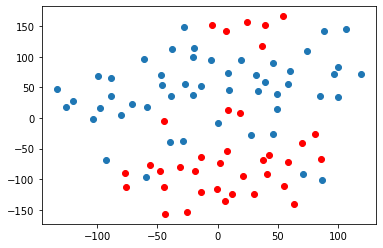

In [16]:
tsne = TSNE(perplexity=15)
result = tsne.fit_transform(np.array(x))
plt.scatter(result[np.where(y=='friendship')].T[0], result[np.where(y=='friendship')].T[1])
plt.scatter(result[np.where(y=='loneliness')].T[0], result[np.where(y=='loneliness')].T[1], color='r')

In [58]:
#embed some jouranl entry:
journal = '''
I worked on my homework quickly so I could join my friends at the party. Every year, my birthday is during dead week, so I never get to celebrate - however, this year, they surprised me with a cake! 
It was the first good birthday I had in college.'''

journaltest = '''
Depressed. Relationship of 1.5 years ended a month ago and I'm still depressed about it. I'm just taking it day by day. 
'''

journaltest2 = '''
I have a friend who lived in Cali for school (I’m east coast.) while she was there, her parents FaceTimed her to tell her they were getting a divorce. She called me, and I immediately booked my $1,000 plane ticket for two days from then. That trip ended up being really fun, but it was so good to be able to be there for her.

A few years later, I lost my mom very suddenly. I didn’t know how to cope or move on with life. This same friend came over and spent every night at my apartment listening to me cry and try to figure out how to make funeral arrangements and estate decisions. As much as it sucked, it was awesome having such a good friend, and knowing that either of us would drop everything for each other.

'''
journaltest3 = '''
I went with my family yesterday to a beach in Palos Verdes. I enjoyed seeing the way my parents interacted with each other, and love showing my little sister all the stuff and watching her discover them for the first time. I was like, "do I want kids?""'''

irrelevantjournal = '''
In September, The Oaklandside launched a reader survey to gather information about people’s experiences on our city’s dangerous roadways. More than a third of the 100-plus people who responded told us that red-light running is a major concern. Respondents were from neighborhoods across the city and included Black, Latinx, and Asian residents in the East Oakland flatlands, where collisions occur more frequently. One person told us that she saw a car burst through a red light on Grand Avenue and Mandela Parkway in West Oakland, colliding with another vehicle and throwing it in the air. It landed two feet from her car. Another Oaklander said he was hit by a car running a red light at an intersection downtown while biking to work but avoided serious injury by swerving. 
'''

irrelevantjournal = '''
recently, i’ve become a bigger believer in a “common good”. I see many people threading through the same struggles and epiphanies in life, I see that what people thought about thousands of years ago is similar to what people think about and struggle with now - I believe that enlightenment is possible in bursts, and that as a human being, I’m going to rediscover the same mistakes and insights as many other humans have for centuries - and there’s nothing good or bad about that, it just -is- part of my human condition

'''
journal_sentences = split_into_sentences(journal)
journal_embeddings = []
for d in journal_sentences:
    print(d)
    journal_embeddings.append((d, model.encode(d)))
    
whole_journal_embedding = model.encode(journaltest3)

I went with my family yesterday to a beach in Palos Verdes.
I enjoyed seeing the way my parents interacted with each other, and love showing my little sister all the stuff and watching her discover them for the first time.
I was like, "do I want kids"?
"


In [59]:
all_entry_distance_pairs = []
for entry in all_entries:
    dist = np.linalg.norm(whole_journal_embedding - entry[2])
    all_entry_distance_pairs.append((entry[1], dist, entry[0], entry[3], entry[4]))
results = sorted(all_entry_distance_pairs, key=lambda x: x[1])

connection_score = 0
for r in results[:10]:
    connection_score += {'friendship':1, 'loneliness':-1}[r[2]]
print(connection_score)
results

-8


[('I moved to a new town for university, but had 6 weeks to kill before the first semester started. Those 6 weeks were spent in solitude. I only went outside twice to buy food, and when I didn’t sleep I played single player video games or read books.  Basically had no human interaction at all. Was pretty enjoyable, honestly.',
  1.1099892,
  'loneliness',
  'Unknown',
  './loneliness/17.txt'),
 ("They are so caught up in their happiness that they don't realize I'm not really a part of it. I am wandering along the periphery. I am like the people in the Winslow Homer paintings, sharing the same room with them but not really there. I am like the fish in the aquarium, thinking in a different language, adapting to a life that's not my natural habitat. I am the people in the other cars, each with his or her own story, but passing too quickly to be noticed or understood.  . . . There are moments I just sit in my frame, float in my tank, ride in my car and say nothing, think nothing that conne

In [ ]:
# big q: is there a way to do this in general? Some kind of distance threshold to qualify something as lonely or friendly?